# Import Statements

In [1]:
import numpy as np
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Database connection

In [2]:
#define the database (in the current working directory)
db = "database.sqlite"

In [3]:
#connect to the db
conn = sqlite3.connect(db)

#display the tables in the dataset
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table'
                     """, conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,Salaries,Salaries,2,CREATE TABLE Salaries (\n Id INTEGER PRIMAR...


# Data Loading

In [4]:
#define the salaries dataframe from the db now that we know the tables in the database
salaries = pd.read_sql('''SELECT * FROM Salaries''', conn)

#check out the head of salaries df to see what we're working with
salaries.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,,567595.43,567595.43,2011,,San Francisco,
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245132,137811,,538909.28,538909.28,2011,,San Francisco,
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739,106088,16452.6,,335279.91,335279.91,2011,,San Francisco,
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916,56120.7,198307,,332343.61,332343.61,2011,,San Francisco,
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134402,9737,182235,,326373.19,326373.19,2011,,San Francisco,


# Quick EDA

In [5]:
#thats a good chunk of data! And we have 13 features, ok cool
salaries.shape

(148654, 13)

In [6]:
#This is the feature space, agency is either irrelevant (everyone is in SF) or the dataset is of government employees
#damn with that salary? May drop that column later.
salaries.columns

Index(['Id', 'EmployeeName', 'JobTitle', 'BasePay', 'OvertimePay', 'OtherPay',
       'Benefits', 'TotalPay', 'TotalPayBenefits', 'Year', 'Notes', 'Agency',
       'Status'],
      dtype='object')

In [7]:
#the data is from 2011 to 2014 so these salaries are low compared to 2019! Yikes
salaries['Year'].unique()

array([2011, 2012, 2013, 2014], dtype=int64)

In [8]:
#as suspsected 'Agency' is useless. Bye.
salaries['Agency'].unique()

array(['San Francisco'], dtype=object)

In [9]:
salaries = salaries.drop(columns='Agency')

In [10]:
#look at us, no null values...that's not likely, but thanks Kaggle.
salaries.isnull().sum()

Id                  0
EmployeeName        0
JobTitle            0
BasePay             0
OvertimePay         0
OtherPay            0
Benefits            0
TotalPay            0
TotalPayBenefits    0
Year                0
Notes               0
Status              0
dtype: int64

In [11]:
#will need to convert those objects to ints for sure
salaries.dtypes

Id                    int64
EmployeeName         object
JobTitle             object
BasePay              object
OvertimePay          object
OtherPay             object
Benefits             object
TotalPay            float64
TotalPayBenefits    float64
Year                  int64
Notes                object
Status               object
dtype: object

# Data Cleaning as Deemed Necessary by Initial EDA

In [12]:
#the error thrown here told me that while I thought there were no null values before, the null values 
#are actually the string "Not Provided" so I will remove that now.
#details: returned a ValueError: ('Unable to parse string "Not Provided" at position 148646', 'occurred at index BasePay')
salaries = salaries[['BasePay', 'OvertimePay', 'OtherPay', 'Benefits']].apply(pd.to_numeric)

ValueError: ('Unable to parse string "Not Provided" at position 148646', 'occurred at index BasePay')

# Removing Null Values

In [13]:
#removes the rows that contain "Not Provided"
salaries = salaries[~salaries['BasePay'].isin(['Not Provided'])]

In [14]:
salaries[['BasePay', 'OvertimePay', 'OtherPay', 'Benefits']] = salaries[['BasePay', 'OvertimePay', 'OtherPay', 'Benefits']].apply(pd.to_numeric)

In [15]:
#double checked that it only removed 4 instances :)
salaries.shape

(148650, 12)

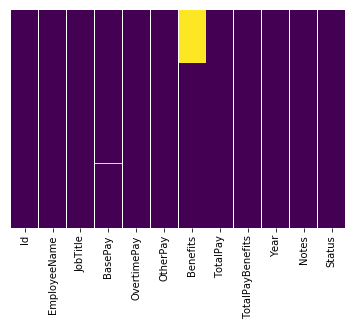

In [16]:
#I realized that pd.to_numeric applied to the df introduced NaNs. Check it out:
#Actually, for some reason these NaNs are behaving weird. Here they are:
sns.heatmap(salaries.isnull(), yticklabels=False, cbar=False, cmap='viridis');

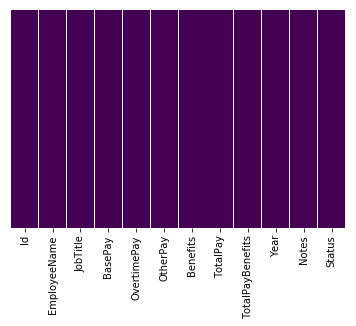

In [17]:
#Now I can make a new df with noNaN and compare how much volume was lost
salaries_noNaN = salaries.dropna()

#doing a new df to compare how many rows we lost
sns.heatmap(salaries_noNaN.isnull(), yticklabels=False, cbar=False, cmap='viridis');

# EDA and Data Cleaning Continued

In [18]:
class format:
    BOLD = '\033[1m'
    UNBOLD = '\033[0m'

print("The new dataframe size is: " + format.BOLD + str(salaries_noNaN.shape[0]) + format.UNBOLD)
print("The old dataframe size is: " + format.BOLD + str(salaries.shape[0]) + format.UNBOLD)

print( "We lost " + format.BOLD + "{0:.0f}%".format(1/4 * 100) + format.UNBOLD + " of the observations.")

The new dataframe size is: 111886
The old dataframe size is: 148650
We lost 25% of the observations.


In [19]:
salaries.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,148650.0,74325.500047,42911.703176,1.00,37163.2500,74325.50,111487.7500,148654.00
BasePay,148045.0,66325.448840,42764.635495,-166.01,33588.2000,65007.45,94691.0500,319275.01
OvertimePay,148650.0,5066.059886,11454.380559,-0.01,0.0000,0.00,4658.1750,245131.88
OtherPay,148650.0,3648.767297,8056.601866,-7058.59,0.0000,811.27,4236.0650,400184.25
Benefits,112491.0,25007.893151,15402.215858,-33.89,11535.3950,28628.62,35566.8550,96570.66
TotalPay,148650.0,74770.333901,50516.196009,-618.13,36169.9550,71427.24,105842.9600,567595.43
TotalPayBenefits,148650.0,93695.075969,62792.497391,-618.13,44073.3375,92406.02,132877.9925,567595.43
Year,148650.0,2012.522603,1.117526,2011.00,2012.0000,2013.00,2014.0000,2014.00


In [20]:
#another useless column. dropping
salaries['Notes'].unique()

array([''], dtype=object)

In [21]:
salaries_noNaN = salaries_noNaN.drop(columns=['Notes'])
salaries_histogrammable = salaries_noNaN.drop(columns=['EmployeeName', 'JobTitle', 'Status'])

#salaries_histogrammable is my quantitative dataframe that I can run algorithms on so I'm going to clean that one up now too
salaries_histogrammable[['BasePay', 'OvertimePay', 'OtherPay', 'Benefits']] = salaries_histogrammable[['BasePay', 'OvertimePay', 'OtherPay', 'Benefits']].apply(pd.to_numeric)

salaries_histogrammable = salaries_histogrammable.dropna()

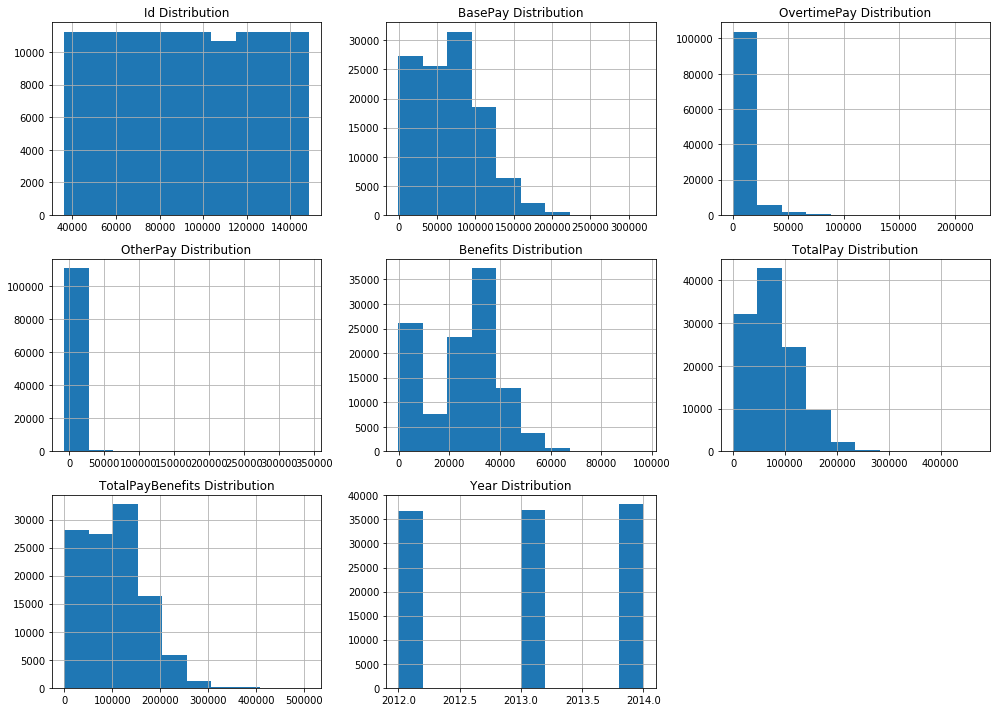

In [22]:
#Looking at the histograms below we can see that the sampling method behind this study is a bit biased.
#It looks like only extreme values are present.
def histogram_grid(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(14,10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

histogram_grid(salaries_histogrammable, salaries_histogrammable.columns, 3, 3)

<h2>Takeaways from the above graph</h2>
<p>The majority of base pay is below $100,000. That's coo.</p>

In [23]:
#checking out the average pay before benefits by year, #we lost 2011 because they didn't have benefits data
salaries_noNaN[['Year', 'TotalPay']].groupby('Year').mean()

,TotalPay
Year,
2012,74113.262265
2013,78808.285041
2014,75471.836912


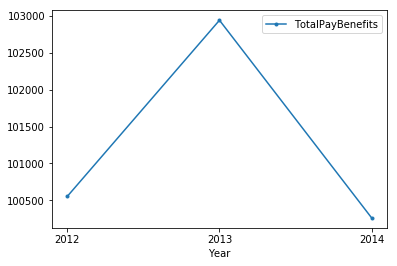

In [24]:
#This data looks much more reasonable. Let's look at the change with a dot chart. It looks like there was a spike in 2013
#in average pay with benefits.
year_pay_benefits = salaries_noNaN[['Year', 'TotalPayBenefits']].groupby('Year').mean().plot(style='.-', xticks=[2012, 2013, 2014])
year_pay_benefits

# Machine Learning

Preparing the dataset for different algorithms

In [25]:
#Now I'm going to use status PT or FT as my binary classifier, my dependent variable
#and use different algorithms to predict employment status by BasePay and such.
pt = salaries_noNaN[salaries_noNaN['Status'] == 'PT']

ft = salaries_noNaN[salaries_noNaN['Status'] == 'FT']

#We can see by the difference in shapes that there are status values other than FT and PT. What are they you may ask?

print(ft.shape)
print(pt.shape)
print(salaries_noNaN.shape)

(22334, 11)
(15785, 11)
(111886, 11)


In [26]:
#They are empty strings! Bye bye!
salaries_noNaN[salaries_noNaN['Status'] == ''].head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Status
36159,36160,Gary Altenberg,"Lieutenant, Fire Suppression",128808.87,220909.48,13126.31,44430.12,362844.66,407274.78,2012,
36160,36161,Gregory Suhr,Chief of Police,302578.00,0.00,18974.11,69810.19,321552.11,391362.30,2012,
36161,36162,Khoa Trinh,Electronic Maintenance Tech,111921.00,146415.32,78057.41,53102.29,336393.73,389496.02,2012,
36162,36163,Joanne Hayes-White,"Chief, Fire Department",296943.01,0.00,17816.59,72047.88,314759.60,386807.48,2012,
36163,36164,Frederick Binkley,EMT/Paramedic/Firefighter,126863.19,192424.49,17917.18,44438.25,337204.86,381643.11,2012,


In [27]:
salaries_noNaN = salaries_noNaN[(salaries_noNaN.Status == 'FT') | (salaries_noNaN.Status == 'PT')]

In [28]:
#check and make sure that it worked, that ft and pt are the same length as the new salaries_noNaN
pt.shape[0] + ft.shape[0] == salaries_noNaN.shape[0]

True

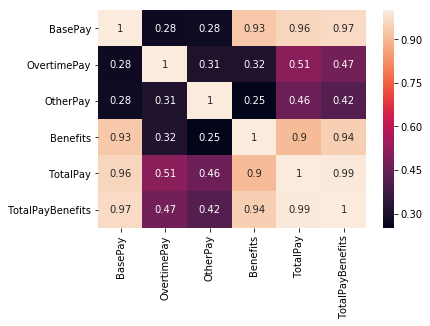

In [39]:
#quantiative variables that make sense for a heatmap of correlations
corr_matrix_quants = salaries_noNaN.iloc[:,3:-2]

sns.heatmap(corr_matrix_quants.corr(), annot=True);

<p>This makes sense because there weren't a lot of benefits in the dataset and there the base pay was the biggest value, so total pay and base pay are highly correlated, as are total pay and benefits, and total pay with benefits with total pay.</p>

# Data Cleaning for Binary Classification

I'll use the status variable (a binary classifier) as my y variable. 
I will run a linear regression model and then a logistic one.

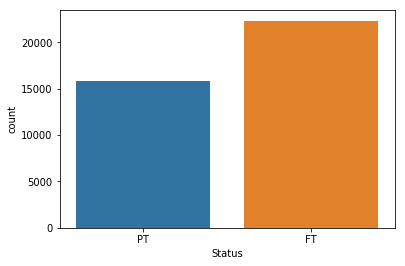

In [40]:
sns.countplot(x='Status', data=salaries_noNaN)

The majority of employees are fulltime, no surprises there.

In [31]:
#I was hoping I could disaggregate the data by job title or at least cluster them into a industry variable
#but that would be a lot of work. I may come back to this column with NLP
len(salaries_noNaN['JobTitle'].unique())

996

In [32]:
salaries_noNaN.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Status
110531,110532,David Shinn,Deputy Chief 3,129150.01,0.00,342802.63,38780.04,471952.64,510732.68,2014,PT
110532,110533,Amy P Hart,Asst Med Examiner,318835.49,10712.95,60563.54,89540.23,390111.98,479652.21,2014,FT
110533,110534,William J Coaker Jr.,Chief Investment Officer,257340.00,0.00,82313.70,96570.66,339653.70,436224.36,2014,PT
110534,110535,Gregory P Suhr,Chief of Police,307450.04,0.00,19266.72,91302.46,326716.76,418019.22,2014,FT
110535,110536,Joanne M Hayes-White,"Chief, Fire Department",302068.00,0.00,24165.44,91201.66,326233.44,417435.10,2014,FT


In [44]:
#made the status FT = 1 and PT = 0 to be able to work with it with regression models
salaries_binary = salaries_noNaN.replace(to_replace=['FT', 'PT'],
                             value=[1,0])

salaries_binary = salaries_binary.iloc[:,4:]
salaries_binary.head()

,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Status
110531,0.00,342802.63,38780.04,471952.64,510732.68,2014,0
110532,10712.95,60563.54,89540.23,390111.98,479652.21,2014,1
110533,0.00,82313.70,96570.66,339653.70,436224.36,2014,0
110534,0.00,19266.72,91302.46,326716.76,418019.22,2014,1
110535,0.00,24165.44,91201.66,326233.44,417435.10,2014,1


# Linear Regression

In [45]:
def linear_regression(df, x_columns, y_column):
    '''Takes a dataframe, the x variables (columns of the 
    dataframe) to be trained on as an array and the 
    y column to use in predictions and testing variable 
    and returns the coefficients for each x variable 
    on y (the dependent variable).
    
    Requires a dataframe with only quantitative values, 
    no strings.
    
    Example of the required data cleaning and then function call:
    df = pd.read_csv("loan_data.csv")
    df = df.drop(['string columns'], axis=1)
    x_columns = df['x_a', 'x_b', ...'x_n']
    y_column = df['y_variable']
    
    linear_regression(df, x_columns, y_column)
    
    
                Coeff
    credit.policy	 11.359122
    inq.last.6mths	 0.236195
    installment	     0.040879
    days.with.cr.li  0.002172
    revol.bal	     0.000043
    dti	-0.224324
    log.annual.inc	-0.238352
    revol.util	-0.361837
    not.fully.paid	-2.132126
    delinq.2yrs	-9.282614
    pub.rec	-10.164147
    int.rate	-786.193923
    '''
    X = x_columns
    y = y_column
    
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    from sklearn.linear_model import LinearRegression
    
    lm = LinearRegression()
    
    lm.fit(X_train, y_train)
    
    cdf = pd.DataFrame(lm.coef_,X.columns,columns=['Coeff'])
    
    return cdf.sort_values('Coeff', ascending=False)

In [48]:
x_columns = salaries_binary.iloc[:,:-1]
y_column = salaries_binary['Status']

linear_regression(salaries_binary, x_columns, y_column)

,Coeff
TotalPayBenefits,6.091727e+06
OvertimePay,7.059126e-06
Year,0.000000e+00
OtherPay,-2.028614e-06
Benefits,-6.091727e+06
TotalPay,-6.091727e+06


In [49]:
import statsmodels.api as sm
from scipy import stats

X = x_columns
y = y_column

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Status   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                 1.344e+04
Date:                Tue, 15 Jan 2019   Prob (F-statistic):               0.00
Time:                        13:42:25   Log-Likelihood:                -7727.4
No. Observations:               38119   AIC:                         1.547e+04
Df Residuals:                   38113   BIC:                         1.552e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
OvertimePay       7.188e-06   1.63e-07  

In [75]:
#The only statistically insignificant variable is year, so I will drop that here to not overfit my model
#It also didn't have a large coefficient in the table earlier.
x_columns = salaries_binary.iloc[:,:-1].drop(columns='Year')
y_column = salaries_binary['Status']

linear_regression(salaries_binary, x_columns, y_column)

,Coeff
TotalPayBenefits,3.632880e+06
OvertimePay,7.035750e-06
OtherPay,-2.216684e-06
Benefits,-3.632880e+06
TotalPay,-3.632880e+06


# Logistic Regression Model

In [76]:
from sklearn.model_selection import train_test_split

X = salaries_binary.drop('Status', axis=1)
y = salaries_binary['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

from sklearn.linear_model import LogisticRegression

#instantiate the model
logmodel = LogisticRegression()

logmodel.fit(X_train, y_train)

c:\users\riley\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [77]:
#predict values based on X_test data
predictions = logmodel.predict(X_test)

In [78]:
from sklearn.metrics import classification_report, confusion_matrix

print(format.BOLD + "Classification Report: " + format.UNBOLD)
print(classification_report(y_test, predictions))

print(format.BOLD + "Confusion Matrix: " + format.UNBOLD)
print(confusion_matrix(y_test, predictions))

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      4705
           1       0.90      0.98      0.94      6731

   micro avg       0.92      0.92      0.92     11436
   macro avg       0.93      0.91      0.92     11436
weighted avg       0.92      0.92      0.92     11436

Confusion Matrix: 
[[3939  766]
 [ 146 6585]]


<p>Precision on the PT label was more accurate than on the FT data even though FT had more data points.</p>
<p><b>Full breakdown:</b></p>
<p><b>Classification Report: </b><br />
-Precision 0: It was 96% precise in not wrongly labeling FT a sample that was PT. <br />
-Precision 1: The model was 89% precise in not wrongly labeling PT a sample that was FT. <br />
-Recall 0: The ability of the model to find all positive samples of PT. <br />
-Recall 1: Same but for FT. <br />
-f1-score 0: The weighted harmonic mean for precision and recall on PT status. <br />
-f1-score 1: The weighted harmonic mean for precision and recall on FT status. <br />
-support 0: The number of times that PT status was true. <br />
-support 1: The number of times that FT status was true. <br /></p>

<p><b>Confusion Matrix: </b><br />
True positive: the model guessed in 3929 instances correctly that the status was FT. <br />
False positive: the model guessed in 776 instances that the work status was FT when it was in fact PT. <br />
False negative: the model guessed in 145 instances that the status was PT when it was in fact FT. <br />
True positive: the model guessed in 6586 instances correctly that the status was PT and not FT. <br />
</p>

<p>In review: when we corroborate between the confusion matrix and the classification report, we can see that both of these evaluation methods reveal that the model was in fact better at correctly classifying PT over FT.</p>

# Decision Tree Classifier

In [58]:
#train a single decision tree to start
from sklearn.tree import DecisionTreeClassifier

In [59]:
dtree = DecisionTreeClassifier()

In [60]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [61]:
predictions = dtree.predict(X_test)

In [62]:
print(format.BOLD + "Classification Report: " + format.UNBOLD)
print(classification_report(y_test, predictions))

print(format.BOLD + "Confusion Matrix: " + format.UNBOLD)
print(confusion_matrix(y_test, predictions))

Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4705
           1       0.94      0.95      0.95      6731

   micro avg       0.94      0.94      0.94     11436
   macro avg       0.93      0.93      0.93     11436
weighted avg       0.94      0.94      0.94     11436

Confusion Matrix: 
[[4324  381]
 [ 346 6385]]


<p>Precision on the FT label was more accurate than on the PT data for this model. It may be a better fit.</p>
<p><b>Full breakdown:</b></p>
<p><b>Classification Report: </b><br />
-Precision 0: It was 94% precise in not wrongly labeling FT a sample that was PT. <br />
-Precision 1: The model was 95% precise in not wrongly labeling PT a sample that was FT. <b>**Considerably better than the log regression model.</b><br />
-Recall 0: The ability of the model to find all positive samples of PT. 93% <br />
-Recall 1: Same but for FT. 96% <br />
-f1-score 0: The weighted harmonic mean for precision and recall on PT status. 93% <br />
-f1-score 1: The weighted harmonic mean for precision and recall on FT status. 95% <br />
-support 0: The number of times that PT status was true. <br />
-support 1: The number of times that FT status was true. <br /></p>

<p><b>Confusion Matrix: </b><br />
True positive: the model guessed in 4361 instances correctly that the status was FT. <br />
False positive: the model guessed in 344 instances that the work status was FT when it was in fact PT. <br />
False negative: the model guessed in 300 instances that the status was PT when it was in fact FT. <br />
True positive: the model guessed in 6431 instances correctly that the status was PT and not FT. <br />
</p>

<p>In review: when we corroborate between the confusion matrix and the classification report, there is less of a clear distinction in terms of how well it could predict FT status. The classification report showed it as a winner, but the margins are a bit smaller in the confusion matrix.</p>

# Random Forest Classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
rfc = RandomForestClassifier(n_estimators=200)

In [65]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
rfc_pred = rfc.predict(X_test)

In [67]:
print(format.BOLD + "Classification Report: " + format.UNBOLD)
print(classification_report(y_test, rfc_pred))

print(format.BOLD + "Confusion Matrix: " + format.UNBOLD)
print(confusion_matrix(y_test, rfc_pred))

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4705
           1       0.95      0.98      0.96      6731

   micro avg       0.95      0.95      0.95     11436
   macro avg       0.95      0.95      0.95     11436
weighted avg       0.95      0.95      0.95     11436

Confusion Matrix: 
[[4326  379]
 [ 165 6566]]


<p>Overall this is the best fit for FT status prediction of all the models.</p>

<p>In review: Higher precision and recall than the other two models and more true positives and true negatives! You go random forest!</p>

# K Means Clustering

In [69]:
from sklearn.cluster import KMeans

In [70]:
kmeans = KMeans(n_clusters=2)

In [71]:
kmeans.fit(salaries_binary.drop('Status', axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [72]:
kmeans.cluster_centers_

array([[  9883.2323672 ,   5866.00309598,  36996.4334458 ,
        117816.16310678, 154812.59655258,   2014.        ],
       [  1165.68527175,   1273.86125542,  13249.95642715,
         35441.91609441,  48691.87252156,   2014.        ]])

In [73]:
from sklearn.metrics import confusion_matrix, classification_report

print(format.BOLD + "Classification Report: " + format.UNBOLD)
print(classification_report(salaries_binary['Status'], kmeans.labels_))

print(format.BOLD + "Confusion Matrix: " + format.UNBOLD)
print(confusion_matrix(salaries_binary['Status'], kmeans.labels_))

Classification Report: 
              precision    recall  f1-score   support

           0       0.11      0.13      0.12     15785
           1       0.30      0.26      0.28     22334

   micro avg       0.21      0.21      0.21     38119
   macro avg       0.21      0.20      0.20     38119
weighted avg       0.22      0.21      0.21     38119

Confusion Matrix: 
[[ 2056 13729]
 [16430  5904]]


# Elbow Method for K Means Clustering

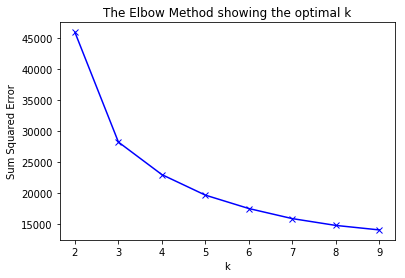

In [74]:
#k means determine k with elbow method
from scipy.spatial.distance import cdist
X = salaries_binary.drop('Status', axis=1)

distortions = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum Squared Error')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The above method doesn't matter because there are only two clusters, FT or PT. But it's interesting to visualize, nonetheless.